# Visual prompting component implementation

In [ ]:
!pip install ultralytics

In [29]:
import torch
import numpy as np
from ultralytics import YOLO
from PIL import Image, ImageDraw, ImageFont
import matplotlib.pyplot as plt
from transformers import AutoProcessor, LlavaForConditionalGeneration
from huggingface_hub import hf_hub_download
import re
import textwrap

In [30]:
print(f"GPU available: {torch.cuda.is_available()}, Device: {torch.cuda.get_device_properties(torch.cuda.current_device()).name}")
device = torch.cuda.current_device()
print(device)

GPU available: True, Device: NVIDIA A100-SXM4-40GB
0


# Load models

In [31]:
yolo = YOLO("yolo11n.pt")

100%|██████████| 5.35M/5.35M [00:00<00:00, 352MB/s]


In [ ]:
model_id = "llava-hf/llava-1.5-13b-hf"
model = LlavaForConditionalGeneration.from_pretrained(
    model_id,
    torch_dtype=torch.float16,
    low_cpu_mem_usage=True,
).to(device)

processor = AutoProcessor.from_pretrained(model_id)

# Object box

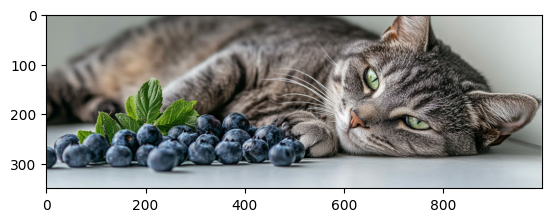

In [5]:
image = Image.open("./images/blueberry.png")
plt.imshow(image)
plt.show()

In [ ]:
results = yolo.predict(image)[0]
cat_cls = 15
object_boxes = [box for box in results.boxes if int(box.cls) == cat_cls]
object_box = object_boxes[0].xyxy[0].cpu().numpy().astype(int)

bounding_box_color = "blue"
object_name = "Blueberry"
object_type = "Cat"

image_with_rectangle = image.copy()
draw = ImageDraw.Draw(image_with_rectangle)
draw.rectangle(object_box.tolist(), outline=bounding_box_color, width=6)

plt.imshow(image_with_rectangle)
plt.show()

# Visual Prompt

## Simple cat example

In [ ]:
task = f"describe what {object_name} is doing?"
context = f"{object_name} is young and playful cat."
max_tokens = 300
prompt_template = f"In this image, the entity enclosed in a {bounding_box_color} box is called {object_name}. \
Without mentioning the bounding box and its color, {task}."
if len(context) > 0:
  prompt_template += f"[Optional] Give more details using the information from: <{context}>"

### Without Bounding Box

In [ ]:
conversation = [
    {

        "role": "user",
        "content": [
            {"type": "text", "text": task},
            {"type": "image"},
        ],
    },
]
prompt = processor.apply_chat_template(conversation, add_generation_prompt=True)
inputs = processor(images=image, text=prompt, return_tensors='pt').to(0, torch.float16)
output = model.generate(**inputs, max_new_tokens=200, temperature=0.9, do_sample=True)

plt.imshow(image)
llava_res = processor.decode(output[0], skip_special_tokens=True)
match = re.search(r"ASSISTANT:\s*(.*)", llava_res, re.DOTALL)
print(match.group(1).strip() if match else llava_res)

### With Bouding Box

In [ ]:
conversation = [
    {
        "role": "user",
        "content": [
            {"type": "text", "text": prompt_template},
            {"type": "image"},
        ],
    },
]

prompt = processor.apply_chat_template(conversation, add_generation_prompt=True)
inputs = processor(images=image_with_rectangle, text=prompt, return_tensors='pt').to(0, torch.float16)
output = model.generate(**inputs, max_new_tokens=200, temperature=0.9, do_sample=True)

plt.imshow(image_with_rectangle)
llava_res = processor.decode(output[0], skip_special_tokens=True)
match = re.search(r"ASSISTANT:\s*(.*)", llava_res, re.DOTALL)
print(match.group(1).strip() if match else llava_res)

## Group of people

In [ ]:
model_path = hf_hub_download(repo_id="AdamCodd/YOLOv11n-face-detection", filename="model.pt")
yolo = YOLO(model_path)


0: 448x640 6 faces, 13.0ms
Speed: 3.5ms preprocess, 13.0ms inference, 2.3ms postprocess per image at shape (1, 3, 448, 640)


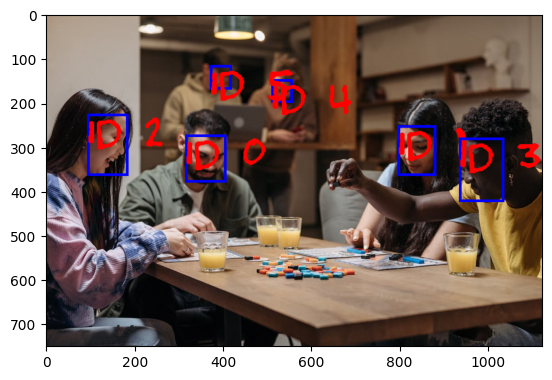

In [15]:
image = Image.open("./images/friends.jpeg")
results = yolo.predict(image)[0]

person_cls = 0
bounding_box_color = "blue"

font = ImageFont.truetype("Humor-Sans.ttf", size=100)
image_ref = image.copy()
draw = ImageDraw.Draw(image_ref)
person_boxes = [box for box in results.boxes if int(box.cls) == person_cls]
for i in range(len(person_boxes)):
    bb = person_boxes[i].xyxy[0].cpu().numpy().astype(int)
    draw.rectangle([(bb[0], bb[1]), (bb[2], bb[3])], outline=bounding_box_color, width=6)
    draw.text((bb[0], bb[1] - 10), f"ID {i}", fill="red", font=font)

plt.imshow(image_ref)
plt.show()

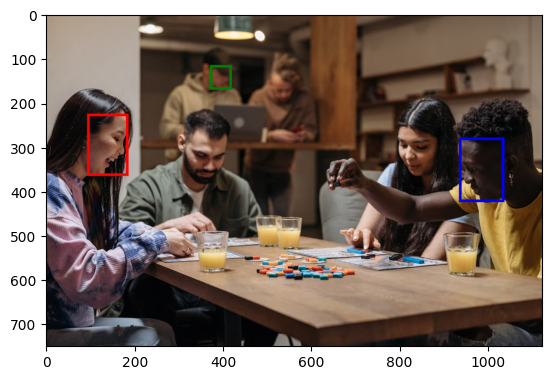

In [8]:
bounding_box_colors = ["blue", "red", "green"]
names               = ["Tom", "Julia", "Jonh"]
persons_id          = [3, 2, 5]

image_with_rectangle = image.copy()
draw = ImageDraw.Draw(image_with_rectangle)
for i, id in enumerate(persons_id):
  person_box = person_boxes[id].xyxy[0].cpu().numpy().astype(int)
  draw.rectangle(person_box.tolist(), outline=bounding_box_colors[i], width=6)

plt.imshow(image_with_rectangle)
plt.show()

### Prompt template

In [18]:
task = f"describe where Tom is in the image and what is the color of his shirt?"
context = f"{', '.join(names)} are friends since high school."
max_tokens = 200
prompt_template = f"In this image, the entities enclosed in {', '.join(bounding_box_colors)} boxes are respectively called {', '.join(names)}. \
Without mentioning the bounding boxes and their color, {task}."
if len(context) > 0:
  prompt_template += f"[Optional] Give more details using the information from: <{context}>"

In [20]:
def prompt_result(question, image, nb_tokens=300, line_break_after=80, temperature=0.9, do_sample=True):
  conversation = [
      {

          "role": "user",
          "content": [
              {"type": "text", "text": question},
              {"type": "image"},
          ],
      },
  ]
  prompt = processor.apply_chat_template(conversation, add_generation_prompt=True)
  inputs = processor(images=image, text=prompt, return_tensors='pt').to(0, torch.float16)
  output = model.generate(**inputs, max_new_tokens=nb_tokens, temperature=temperature, do_sample=do_sample)

  llava_res = processor.decode(output[0], skip_special_tokens=True)
  match = re.search(r"ASSISTANT:\s*(.*)", llava_res)
  cleaned_text = match.group(1).strip()
  return textwrap.fill(cleaned_text, width=line_break_after)


### Without Bouding Box

Tom is sitting at a table and is colorblind. The table has puzzles on top of it,
and he is holding a red cube in his hands. His shirt is green.


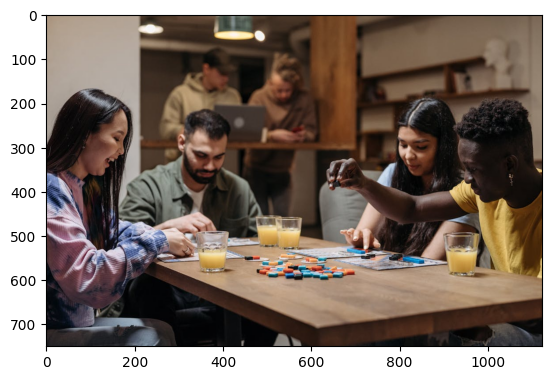

In [21]:
plt.imshow(image)
print(prompt_result(task, image))

### With bounding box

In the image, Tom is seated at a long dining table with his friends Julia and
Jonh. They are enjoying a game or a puzzle event, possibly eating orange slices
as part of the game. Tom is seated between Julia and Jonh, and all three friends
are engaged in the activity. Tom is wearing a green shirt while playing the game
with his friends.


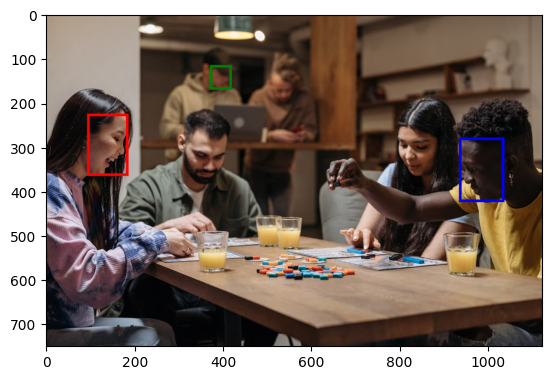

In [27]:
plt.imshow(image_with_rectangle)
print(prompt_result(prompt_template, image_with_rectangle))